In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from kret_studies import *
from kret_studies.notebook_imports import *

In [3]:
features = ["Concentration", "Age", "Weight"]
y_col = ["Clearance"]
names_ordered = features + y_col
df = pd.read_csv("HW3.txt", sep=r"\s+", names=y_col + features, header=0)

In [4]:
df = df[names_ordered]
n = df.shape[0]  # Number of rows in X
p = df[features].shape[1]  # Number of columns in X
Y = df["Clearance"]

In [5]:
df.head(3)

,Concentration,Age,Weight,Clearance
0,0.71,38.0,71.0,132.0
1,1.48,78.0,69.0,53.0
2,2.21,69.0,85.0,50.0


### (a) Obtain the scatterplot matrix. What do the scatter plots suggest about the nature or the functional relationship between Y and the predictor variables?

In [6]:
fig, ax = uks_mpl.subplots(3, height_per=10)
uks_mpl.style_axes(fig, ax)

In [7]:
for i, col in enumerate(features):
    ax[i].scatter(df[col], df[y_col])
    uks_mpl.set_title_label(ax[i], f"{col} vs {y_col[0]}", col, y_col[0])
    ax[i].set_xlabel(col)

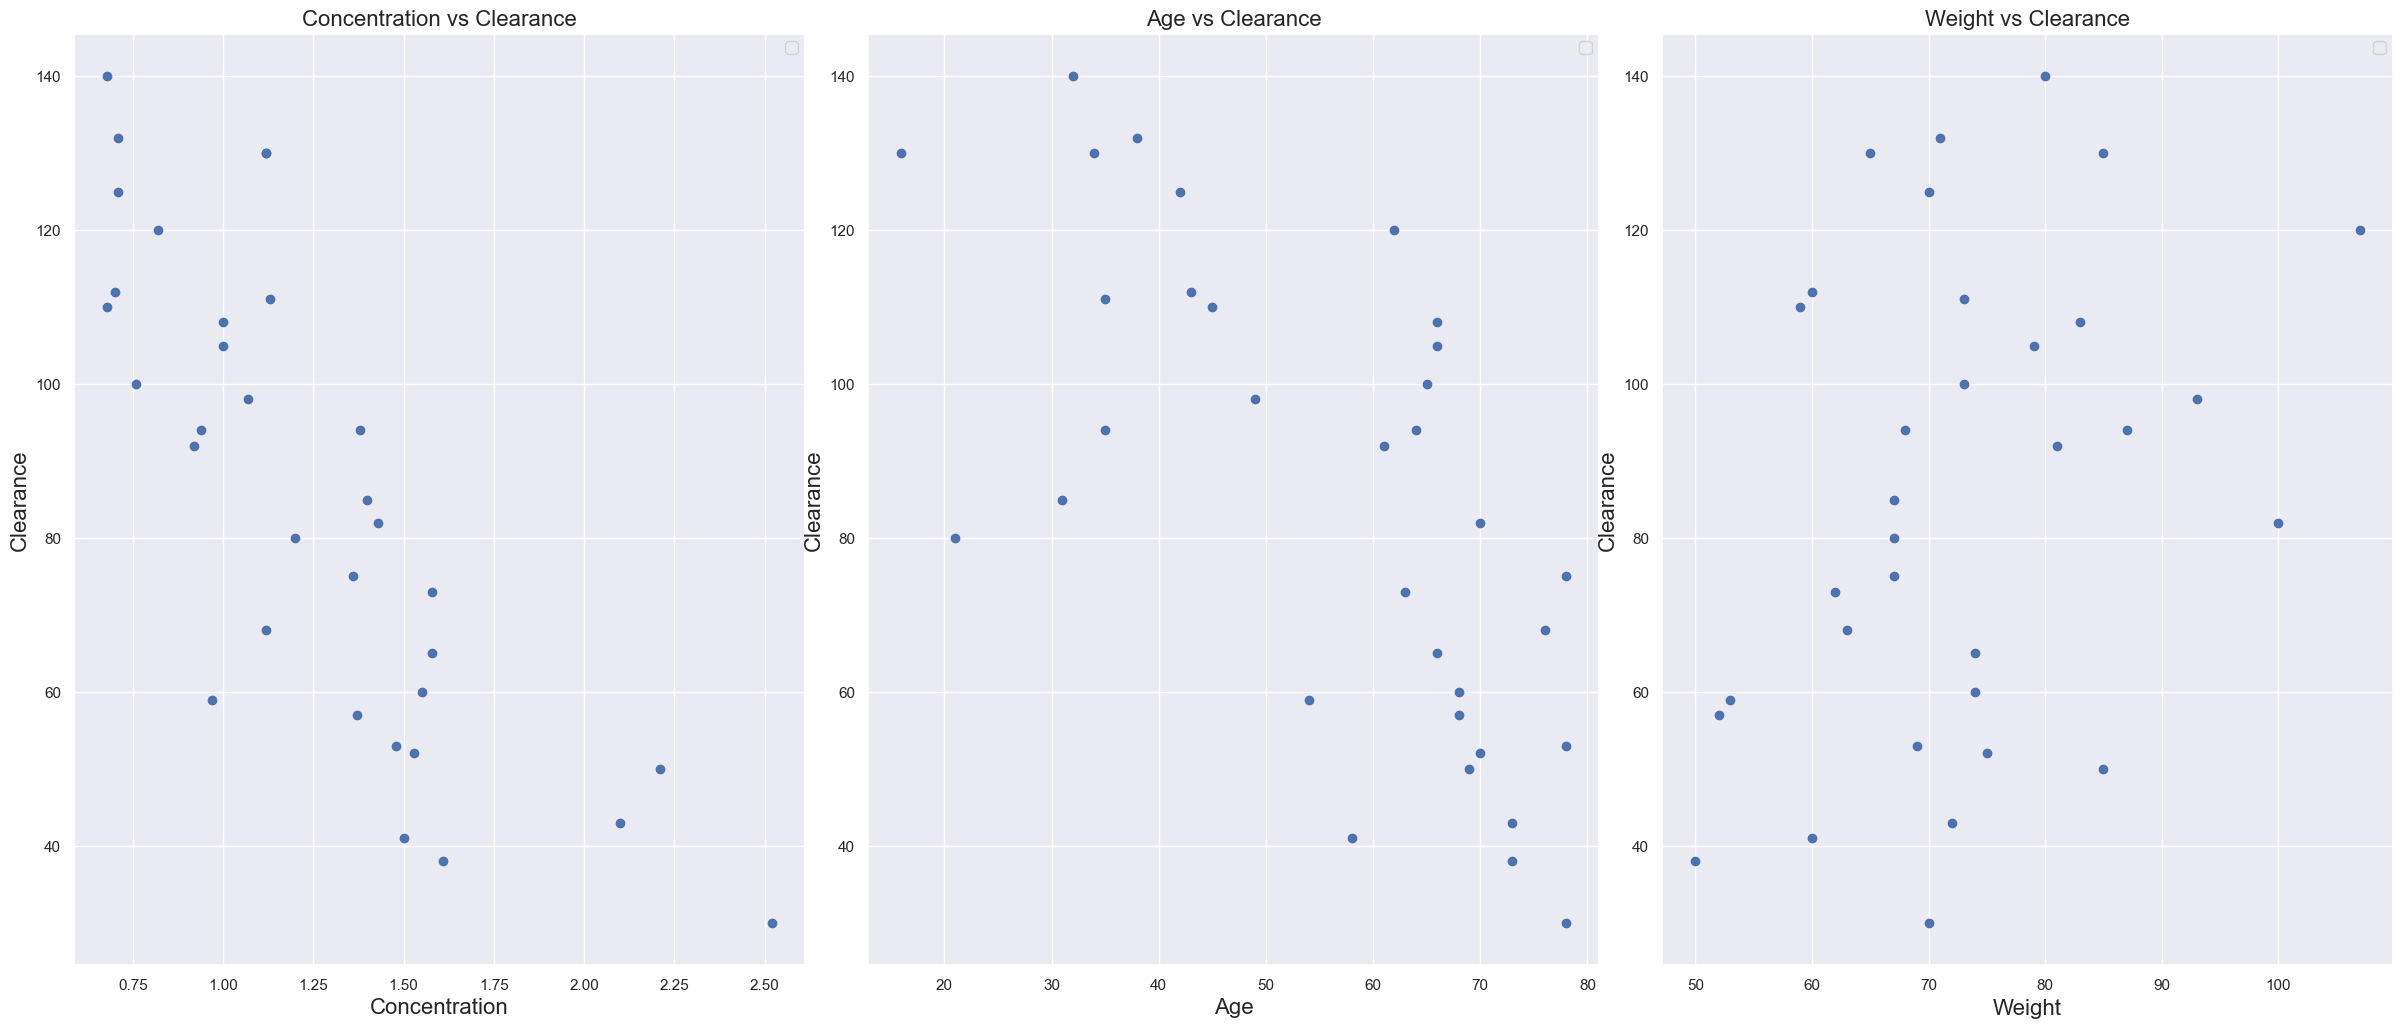

In [8]:
fig

I think that the concentration <--> clerance scatterplot has the tightest grouping. It's worth noting that the relationship doesn't appear to be linear (as in x^1 linear). I would eyeball that a simple a * x^-1 + b approximation, at least within the x & y bounds visible, would have a decent fit. 

Age and clearance appear to be less tightly related. My rough simplification of the relationship would be that age is non-predictive up until age 50, at which point it clearly trends downward. Maybe a -x^2 relationship would explain it decently 

Weight vs clearance is clearly positive (and probably linear), but with very high variance

### (b) Obtain the correlation matrix of the X variables Are any serious multicollinearity problems evident?

In [9]:
corr = df[features].corr()

In [10]:
corr

,Concentration,Age,Weight
Concentration,1.000000,0.467732,-0.088983
Age,0.467732,1.000000,0.068481
Weight,-0.088983,0.068481,1.000000


In [11]:
fig, ax = uks_mpl.subplots(1)
uks_mpl.heatmap_df(corr, ax=ax)
uks_mpl.set_title_label(ax, "Correlation Matrix")

{'annot': True, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x14a972d80>, 'linewidths': 0.1, 'cbar': True, 'vmin': -1.0, 'vmax': 1.0, 'fmt': '.2f', 'ax': <Axes: >}


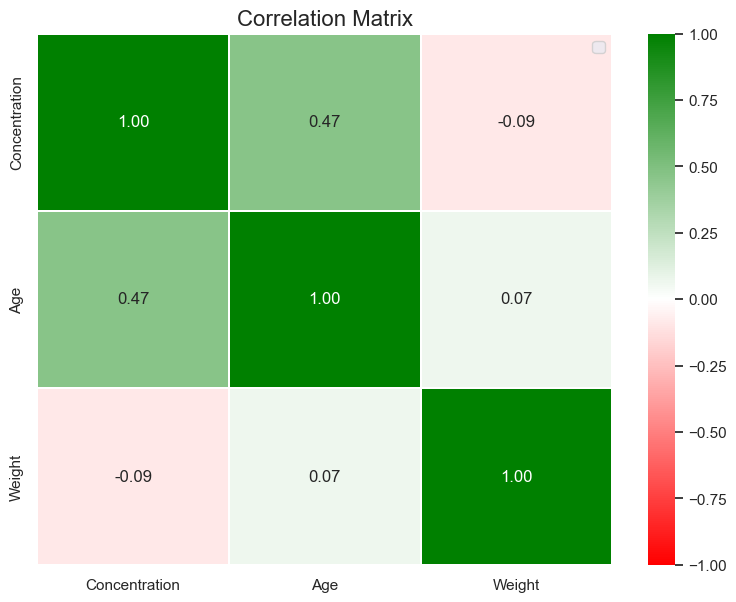

In [12]:
fig

It appears that age and concentration have a pretty strong correlation. This could definitely lead to issues in interpretation of the regression


### (c) Fit the multiple regression function containing the three predictor variables as first-order terms and state the estimated regression function. Report the adjusted R2.

In [13]:
reg = LinearRegression()

In [14]:
reg.fit(df[features], Y)

LinearRegression()

In [15]:
display(reg.coef_)
reg.intercept_

array([-39.93932688,  -0.73676731,   0.7764186 ])

np.float64(120.04728284771434)

In [16]:
r_squared = reg.score(df[features], Y)
r_squared

0.8548185566089759

In [17]:
adjusted_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))

print(f"R-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")

R-squared: 0.8548
Adjusted R-squared: 0.8398


### (d) Plot the residuals against 𝑌". Interpret the plot – do you see any assumptions violated?

In [18]:
formula = uks_stats.get_ols_formula(features, y_col)
model = smf.ols(formula, data=df).fit()

In [19]:
studentized_residuals: np.ndarray = model.get_influence().resid_studentized_external

In [20]:
fig, ax = uks_mpl.subplots(1)

In [21]:
sns.scatterplot(x=model.fittedvalues, y=studentized_residuals, ax=ax)
uks_mpl.format_residual_plot(ax)

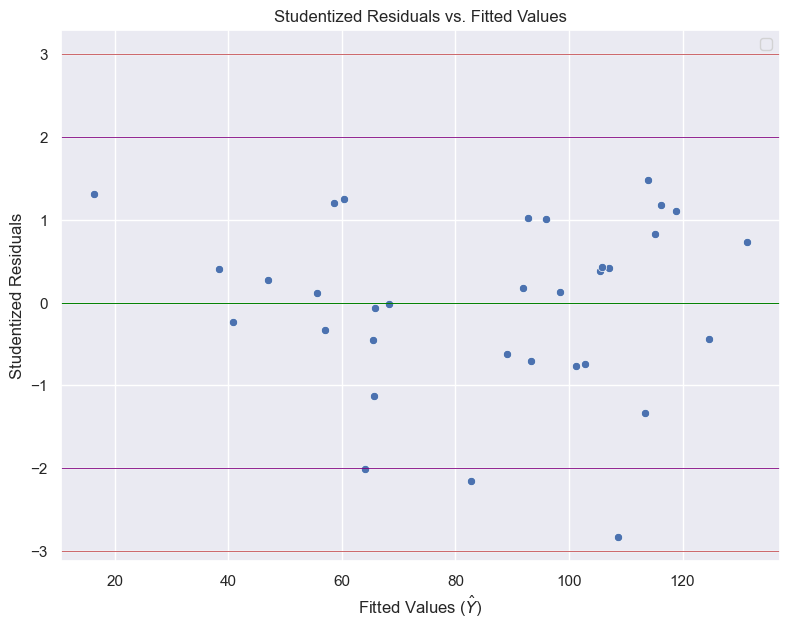

In [22]:
fig

It looks like the assumption of homoskedatisticy is violated

### (e) Prepare a box plot and a Q-Q plot of the residuals. Do they support the normal distribution assumption? Are there any outliers?

In [23]:
fig, ax = uks_mpl.subplots(2)

In [24]:
ax[0].boxplot(model.resid)
uks_mpl.set_title_label(ax[0], "Box Plot Residuals", None, "Residuals")
sm.qqplot(model.resid, line="s", ax=ax[1])
uks_mpl.set_title_label(ax[1], "Q-Q Plot of Residuals")

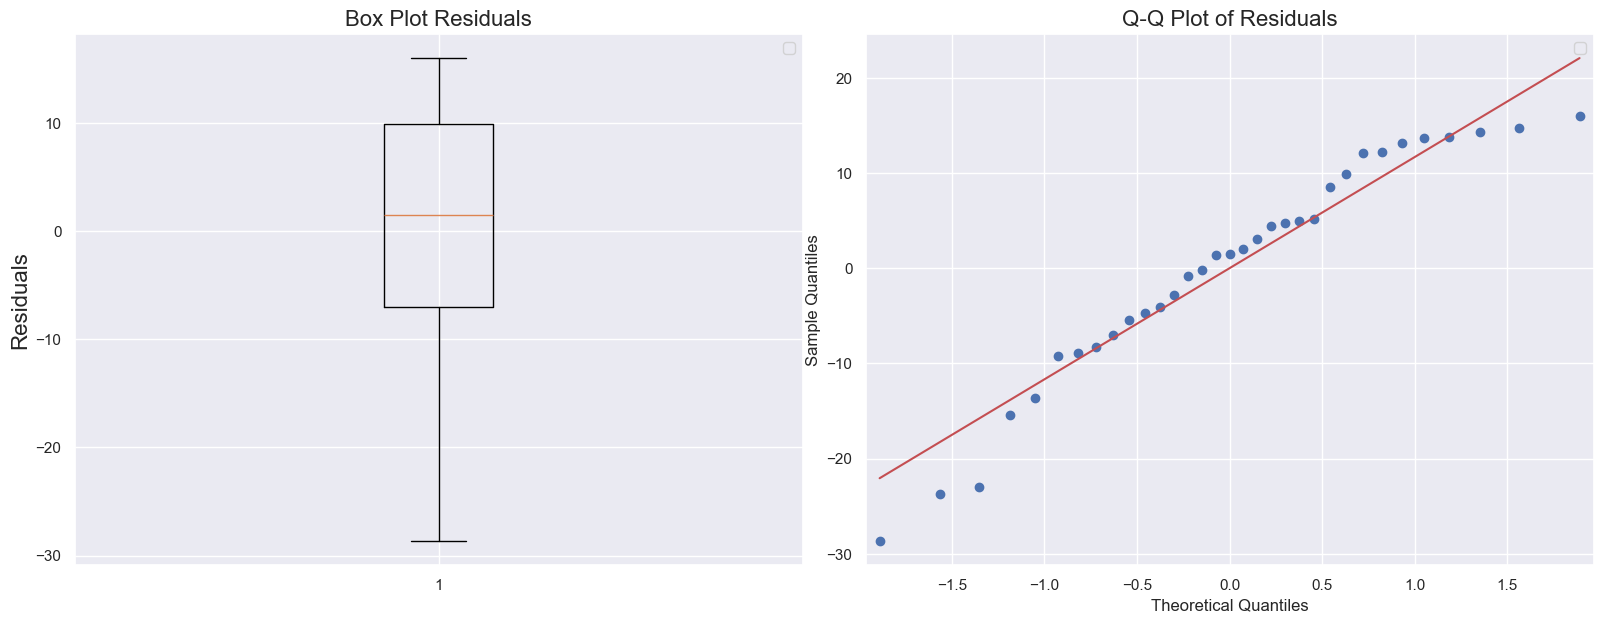

In [25]:
fig

The QQ plot definitely implies that the model's performance deteriorates as we approach the "outliers" (from the y-value perspective, not the x-value perspective)

The Box plot implies that the first IQR is much larger than the other IQRS

### (f) Is at least one predictor significant? Answer with the F-test and a = 0.01

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Clearance   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     56.92
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           2.88e-12
Time:                        16:51:46   Log-Likelihood:                -127.93
No. Observations:                  33   AIC:                             263.9
Df Residuals:                      29   BIC:                             269.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       120.0473     14.774      8.126      0.000      89.832     150.263
Concentration   -39.9393      5.600     -7.132      0.000     -51.393     -28.486
Age              -0.7368      0.141     -5.211      0.000      -1.026      -0.448
Weight            0.7764      0.172      4.517      0.000       0.425       1.128
==============================================================================
Omnibus:                        2.889   Durbin-Watson:                   2.349
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.452
Skew:                          -0.658   Prob(JB):                        0.293
Kurtosis:                       2.768   Cond. No.                         639.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see from the summary, the probability of the f-statistic is miniscule, so there's certainly at least one significant predictor

### (g) Obtain 99 percent confidence intervals for each slope bi. Use the intervals to report which of the individual predictors Xi are significant at a = 0.01

In [27]:
confidence_intervals_99 = model.conf_int(alpha=0.01)  # alpha=0.01 for 99% CI
confidence_intervals_99

,0,1
Intercept,79.325251,160.769314
Concentration,-55.374961,-24.503693
Age,-1.126504,-0.347031
Weight,0.302638,1.250200


Because every single predictor's 99% confidence interval excludes 0, you can conclude that they are all significant at the a = 0.01 level

### (h) Conduct the BP test to determine if the homoscedasticity assumption holds. Use a = 0.0l and state your conclusion

In [28]:
from statsmodels.stats.api import het_breuschpagan

feat_with_intercept = sm.add_constant(df[features], prepend=True)

lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(model.resid, feat_with_intercept)

In [29]:
f"{lm=}, {lm_pvalue=}, {fvalue=}, {f_pvalue=}"

'lm=np.float64(5.114098918873809), lm_pvalue=np.float64(0.1636303962690848), fvalue=np.float64(1.7728058851421906), f_pvalue=np.float64(0.17437596521813828)'

We fail to reject the null hypothesis that there is no heteroskedacity present

### (i) Raw Residual vector

In [30]:
y_hat = reg.predict(df[features])

In [31]:
e = y_hat - Y

In [32]:
np.mean(e)

np.float64(-6.0288474549341836e-15)

### (j) SSR

In [33]:
y_mean = np.mean(Y)

In [34]:
SSR = np.sum(np.square(y_hat - y_mean))
SSR

np.float64(26495.541523169835)

### (k) The covariance matrix of the estimated coefficients, 𝑠^2(𝒃)

In [35]:
model.cov_params()

,Intercept,Concentration,Age,Weight
Intercept,218.262351,-27.650619,-0.426517,-2.138313
Concentration,-27.650619,31.359483,-0.377556,0.132096
Age,-0.426517,-0.377556,0.019992,-0.003039
Weight,-2.138313,0.132096,-0.003039,0.029544


{'annot': True, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x14a972d80>, 'linewidths': 0.1, 'cbar': True, 'vmin': -218.26235050410835, 'vmax': 218.26235050410835, 'fmt': '.2f'}


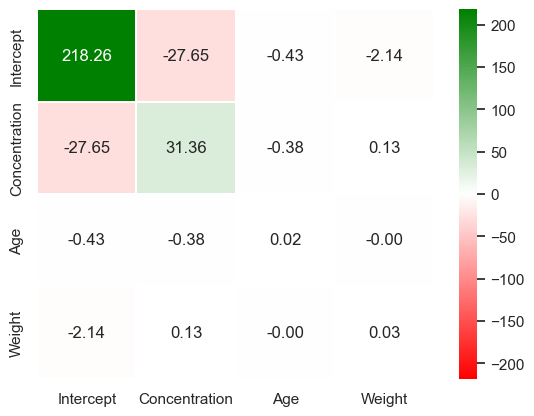

In [36]:
uks_mpl.heatmap_df(model.cov_params(), fmt=".2f")

### (i) The covariance matrix of the fitted value, 𝑠^2(𝒀_h) *, where X1h = 0.94, X2h = 73, and X3h = 73.


In [43]:
new_observation = pd.DataFrame({"Concentration": [0.94], "Age": [73.0], "Weight": [73.0]})

In [ ]:
predictions = model.get_prediction(new_observation)
predictions

In [ ]:
predictions.var_pred_mean, predictions.var_resid, predictions.predicted

(array([17.42254592]), np.float64(155.17150442570093), array([85.39885957]))